<img src="ml2_group_assignment.png" width="800"/>

This notebook just acts as a script to equalize test data as it came from Kaggle so that we can fit our final model into it

In [1]:
#!pip install squarify
#!pip install htmltabletomd
#!pip install GraphViz
#!pip install pygraphviz

In [2]:
import pandas as pd
import numpy as np
import math 
import seaborn as sns  # Graphing
import matplotlib.pyplot as plt
import squarify #treemap
import matplotlib.pyplot as plt
import warnings
import plotly.graph_objects as go
import xgboost as xgb
import scipy.stats as stats
import htmltabletomd
import pydotplus

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn import datasets
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm


from yellowbrick.target import FeatureCorrelation
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import rfecv


from plotly.subplots import make_subplots
from IPython.display import Image  
from io import StringIO


from itertools import combinations

from dtreeviz.trees import *


from numpy import percentile

warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='0'></a>
##  <font color=green>0.Import the Data </font>

Let’s load the original Kaggle training and test data and create a data frame

In [4]:
data_test = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

Let's keep the original dataset for later comparisons and make a copy for the FE process

In [5]:
df_original = data_test.copy()

<a id='5'></a>
<a id='5.1'></a>
# <font color=green>  5.Feature Engineering<font>

<a id='5.2'></a>
## <font color=green> 5.2 Feature Transformation and Building of new features <font>

<a id='5.2.1'></a>
### <font color=green> 5.2.1 Bivariate Combinations <font>

During feature engineering, we want to try to create a wide variety of interactions between multiple variables in order to create new variables. 


By manipulating them together, we create opportunities to have new and impactful features which could potentially impact our target variable, thus engineering our features. 

For this argument, we will create as many bivariate combinations of our predicting variables using the ‘combinations’ method from itertools library.

We will not make interactions with the dummy variables as these are either 0 or 1 and we will not get any additional information from making the interaction this way. 

Furthermore, it is not recommended to use standardization before bivariate combinations as we want to increase the signal. <br>

Sources: https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755 <br>

https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d

In order to use the bivariate combination we split the dataset for using it.Note this is not the split we will use later for testing the algorithm. This has only the purpose of testing all the combination and selecting the best once. 

In [6]:
# Identify and drop our target variable 'Cover_Type' from dataframe
X = data_test

Train Test Split (80/20 size), drop duplicates and missing values


Here, we create every possible bivariate combination to be tested for feature engineering, no dummies


We take categorical variables prior to our feature engineering

In [7]:
column_list = X.columns
filtered_column_list = [column for column in column_list if 'Soil_Type' not in column and 'Wilderness_Area' not in column and 'Id' not in column ] 
interactions = list(combinations(filtered_column_list, 2))
interactions

[('Elevation', 'Aspect'),
 ('Elevation', 'Slope'),
 ('Elevation', 'Horizontal_Distance_To_Hydrology'),
 ('Elevation', 'Vertical_Distance_To_Hydrology'),
 ('Elevation', 'Horizontal_Distance_To_Roadways'),
 ('Elevation', 'Hillshade_9am'),
 ('Elevation', 'Hillshade_Noon'),
 ('Elevation', 'Hillshade_3pm'),
 ('Elevation', 'Horizontal_Distance_To_Fire_Points'),
 ('Aspect', 'Slope'),
 ('Aspect', 'Horizontal_Distance_To_Hydrology'),
 ('Aspect', 'Vertical_Distance_To_Hydrology'),
 ('Aspect', 'Horizontal_Distance_To_Roadways'),
 ('Aspect', 'Hillshade_9am'),
 ('Aspect', 'Hillshade_Noon'),
 ('Aspect', 'Hillshade_3pm'),
 ('Aspect', 'Horizontal_Distance_To_Fire_Points'),
 ('Slope', 'Horizontal_Distance_To_Hydrology'),
 ('Slope', 'Vertical_Distance_To_Hydrology'),
 ('Slope', 'Horizontal_Distance_To_Roadways'),
 ('Slope', 'Hillshade_9am'),
 ('Slope', 'Hillshade_Noon'),
 ('Slope', 'Hillshade_3pm'),
 ('Slope', 'Horizontal_Distance_To_Fire_Points'),
 ('Horizontal_Distance_To_Hydrology', 'Vertical_Distanc

Addition and division has been taken out as it created a lot of noise in the data. The division makes sense if it has a business meaning and the addition only if it is the same scale. 

However we will add the variables which have the same metrics together in a second step but not in a for loop. 

In [8]:
for (key, value) in interactions:
    data_test[key + '_x_' + value] = data_test[key] * data_test[value]
    #data_test[key + '_+_' + value] = data_test[key] + data_test[value]
    #data_test[key + '_divide_' + value] = data_test[key] / data_test[value]

In [9]:
pd.set_option('display.max_columns', None) #to make all columns visible in dataframe now that we have many
data_test.head(1)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620


<a id='5.2.2'></a>
### <font color=green> 5.2.2 Polynomial Features <font>
    
We have just seen how to make two variables interact together, but sometimes the relationship between dependent and independent variables are more complex and not linear. 
    
Polynomials is another way to create new features! A very strong option for new features is increasing the power of a single variable. 
    
For our purposes, we will try and see if all the existing variables, can improve our Baseline by being increased to the  power.<br>
Source: https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755

Here we select only the columns we are interested in, this is from column 2 to 9

In [10]:
X_pf = data_test.iloc[:, 1:10]
X_pf.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
0,2680,354,14,0,0,2684,196,214,156


By default, when running polynomials we lose the name of our labels. This function gives us the ability to preserve it with the name + the transformation done

In [11]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df



Polynominal features of degree two gives us 46 new features. Since we have already enough information, we will not go for Polynominal three to avoid dimensionality issues later on

In [12]:
test_df_pw2 = PolynomialFeatures_labeled(X_pf,2)
pd.set_option('display.max_columns', None)
test_df_pw2.shape

(565892, 55)

There are some fields duplicated with respect to the original df. This is a side effect of the function as normal features are replicated to the power of one which is still the same value so we delete these

In [13]:
column_list = test_df_pw2.columns
cols = [column for column in column_list if '^1' not in column]
test_df_pw2=test_df_pw2[cols]
test_df_pw2.head(1)

,Constant Term,Elevation^2,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2
0,1.0,7182400.0,125316.0,196.0,0.0,0.0,7203856.0,38416.0,45796.0,24336.0


In [14]:
X

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620
1,15122,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,34879,0,0,7120682,539283,579528,407816,17909025,0,0,0,0,0,0,0,0,0,0,34502,2613,2808,1976,86775,0,0,0,0,0,0,0,0,0,0,0,533454,573264,403408,17715450,43416,30552,1341675,32832,1441800,1014600
2,15123,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,43408,40695,0,0,8084740,558878,564304,371681,17211272,240,0,0,47680,3296,3328,2192,101504,0,0,44700,3090,3120,2055,95160,0,0,0,0,0,0,0,0,0,0,0,613880,619840,408260,18905120,42848,28222,1306864,28496,1319552,869128
3,15124,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,65016,46053,0,0,7991550,563472,544509,338625,17267166,408,0,0,70800,4992,4824,3000,152976,0,0,50150,3536,3417,2125,108358,0,0,0,0,0,0,0,0,0,0,0,613600,592950,368750,18803300,41808,26000,1325792,25125,1281174,796750
4,15125,2706,29,19,0,0,

In here, we concatenate our output to consolidate the ponlynomials with the feature combinations

In [15]:
data_test = pd.concat([data_test,test_df_pw2], axis=1)
data_test.head(1)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Constant Term,Elevation^2,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2
0,15121,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620,1.0,7182400.0,125316.0,196.0,0.0,0.0,7203856.0,38416.0,45796.0,24336.0


This results in a huge dataset. Just for curiosity we ran polynomials to the power of three and see that just the resulting dataframe is already bigger than the consolidated one above

<a id='5.2.3'></a>
### <font color=green> 5.2.3 ID <font>

We agree for the test to not remove ID because the ID is the unique indentifier to evaluate


For the train we will remove it as it doesn't add any value to the model

In [16]:
data_test.drop('Id',axis = 1, inplace = True)

<a id='5.2.4'></a>
### <font color=green> 5.2.4 Distance To Hydrology <font>
#### <font color=green> New Features <font>

We combine Vertical distance to Hydrology and Horizontal distance to Hydrology since these two are highly correlated. This suggests to attempt a diagonal distance to hidrology using the Pythagoras theorem.

We will call this newly engineered feature, Distance_To_Hydrology
 
Source : https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9

In [17]:
data_test['Distance_To_Hydrology'] = data_test['Horizontal_Distance_To_Hydrology']**2 +data_test['Vertical_Distance_To_Hydrology']**2
data_test['Distance_To_Hydrology'] = data_test['Distance_To_Hydrology']**0.5
data_test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Constant Term,Elevation^2,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2,Distance_To_Hydrology
0,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620,1.0,7182400.0,125316.0,196.0,0.0,0.0,7203856.0,38416.0,45796.0,24336.0,0.0
1,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,34879,0,0,7120682,539283,579528,407816,17909025,0,0,0,0,0,0,0,0,0,0,34502,2613,2808,1976,86775,0,0,0,0,0,0,0,0,0,0,0,533454,573264,403408,17715450,43416,30552,1341675,32832,1441800,1014600,1.0,7198489.0,0.0,169.0,0.0,0.0,7043716.0,40401.0,46656.0,23104.0,0.0
2,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,43408,40695,0,0,8084740,558878,564304,371681,17211272,240,0,0,47680,3296,3328,2192,101504,0,0,44700,3090,3120,2055,95160,0,0,0,0,0,0,0,0,0,0,0,613880,619840,408260,18905120,42848,28222,1306864,28496,1319552,869128,1.0,7360369.0,256.0,225.0,0.0,0

#### <font color=green> Square root and logarithm Transformation  <font>

Now we are checking the distribution of the newly created variable and see if further transformation is needed. 

The Distance to Hydrology inherits skewness from parent variables. It is positively skewed and has zero values. 

In order to use log we will use log + 1 in order to use logarithm with zero values. 

Source: https://www.youtube.com/watch?v=_c3dVTRIK9c and 

Source_2: https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9

As a rule of thumb, the skewness can be interpreted as follows:
<img src="Skew.png" width=400 height=200 align="center">

Source: https://www.marsja.se/transform-skewed-data-using-square-root-log-box-cox-methods-in-python/

We do some transformations to minimize skewness

In [18]:
#Using the log10+ 1 logarithm 
data_test['log10_Distance_To_Hydrology'] = np.log10(data_test['Distance_To_Hydrology']+1)

In [19]:
#Using the square root 
data_test['sqr_Distance_To_Hydrology'] = data_test['Distance_To_Hydrology']**0.5

#### <font color=green> Results after logarithm and <font color=darkcyan> Square root Transformation<font>

As you can see above, for distance to Hydrology the __square root__ showed a better performance in terms of skewness and is closer to a normal bell shaped than the logarithm transformation. We will be using Square Root as a new feature in the dataset and will frop the others from the dataset.  

For now we only remove log10 but later we will delete also originals

In [20]:
data_test.drop(['log10_Distance_To_Hydrology'], axis=1,inplace=True)

<a id='5.2.5'></a>
### <font color=green> 5.2.5 Horizontal Distance To Roadways <font>

#### <font color=green> Square root and logarithm Transformation  <font>

For log transformation there should be no zeros, negative values and the distribution should be positive skewed( bigger than 1 is positive) hence we are using the square root as you can see for logarithm transformation below the distribution did not improve!!!

#### <font color=green> Results after logarithm and <font color=darkcyan> Square root Transformation<font>

In [21]:
# since we have null values we add plus 1 to avoid log of zero.We are using natural log and log10
data_test['Sqr_Horizontal_Distance_To_Roadways'] = data_test['Horizontal_Distance_To_Roadways']**0.5
data_test['log_Horizontal_Distance_To_Roadways'] = np.log(data_test['Horizontal_Distance_To_Roadways']+1)
data_test['log10_Horizontal_Distance_To_Roadways'] = np.log10(data_test['Horizontal_Distance_To_Roadways']+1)

We achieved the best result again using square root of the Horizontal Distance to Roadways. Similarly as before, we remove failed experiments

In [22]:
data_test.drop(['log_Horizontal_Distance_To_Roadways','log10_Horizontal_Distance_To_Roadways'], axis=1,inplace=True)

<a id='5.2.6'></a>
### <font color=green> 5.2.6 Slope <font>
#### <font color=green> Square root and logarithm Transformation  <font>

In [23]:
print('\033[95m'+ "Skew before transformation\n", data_test['Slope'].skew(), 
      "\nmin\n", data_test['Slope'].min(),
      "\nmax \n", data_test['Slope'].max(),)

Skew before transformation
 0.7941054536577608 
min
 0 
max 
 66


#### <font color=green> Results after logarithm and <font color=darkcyan> Sqrare root Transformation<font>

In [24]:
# since we have null values we add plus 1 to avoid log of zero
data_test['logSlope'] = np.log(data_test['Slope']+1)

In [25]:
data_test['SqrSlope'] = data_test['Slope']**0.5

Since the skweness for the slope shows better performance when using the square root, we will transform the variable into square root as well. 

In [26]:
data_test.drop(['logSlope'], axis=1,inplace=True)

<a id='5.2.7'></a>
### <font color=green> 5.2.7 Horizontal Distance To Fire Points  <font>
#### <font color=green> Transformation  <font>

#### <font color=green> Results after logarithm and <font color=darkcyan> Sqrare root Transformation<font>

In [27]:
# since we have null values we add plus 1 to avoid log of zero
data_test['log_Horizontal_Distance_To_firepoints'] = np.log(data_test['Horizontal_Distance_To_Fire_Points']+1)

In [28]:
#Transform with square root
data_test['sqr_Horizontal_Distance_To_firepoints'] = data_test['Horizontal_Distance_To_Fire_Points']**0.5

Since square root transformation gives the best result in skewness, we will also use sqr for the feature variable.

In [29]:
data_test.drop(['log_Horizontal_Distance_To_firepoints'], axis=1,inplace=True)

<a id='5.2.8'></a>
### <font color=green> 5.2.8 Hillshades <font>
<a id='5.2.8.1'></a>
### <font color=green> 5.2.8.1 Mean Hillshade <font>
#### <font color=green> Creation of new Feature: Mean Hillshade <font>

In [30]:
# We take the average of Hillshades,which gives you the average light exposure of each cover type during the day
data_test['Mean_Hillshade'] = (data_test['Hillshade_9am']+data_test['Hillshade_Noon']+data_test['Hillshade_3pm'])/3

In [31]:
#Itensity of the Hillshade variables in 3 bin siizes with the bin discretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data_test['Mean_Hillshade_bin'] = est.fit_transform(data_test[['Mean_Hillshade']])

In [32]:
data_test[['Mean_Hillshade_bin','Mean_Hillshade']].describe()

,Mean_Hillshade_bin,Mean_Hillshade
count,565892.000000,565892.000000
mean,1.981318,192.764370
std,0.135803,14.374525
min,0.000000,31.666667
25%,2.000000,185.666667
50%,2.000000,195.333333
75%,2.000000,203.000000
max,2.000000,213.666667


In [33]:
print('\033[95m'+"Skew before transformation\n", data_test['Mean_Hillshade'].skew(), 
      "\nmin\n", data_test['Mean_Hillshade'].min(),
      "\nmax\n", data_test['Mean_Hillshade'].max(),)

Skew before transformation
 -1.2916442805135742 
min
 31.666666666666668 
max
 213.66666666666666


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [34]:
data_test['log_Mean_Hillshade'] = np.log(data_test['Mean_Hillshade'])

In [35]:
print('\033[92m'+"Skew after log transformation\n", data_test['log_Mean_Hillshade'].skew(), 
      "\nmin\n", data_test['log_Mean_Hillshade'].min(),
      "\nmax\n", data_test['log_Mean_Hillshade'].max(),)

Skew after log transformation
 -1.7784116026520227 
min
 3.455264602932431 
max
 5.36441716825256


In [36]:
data_test['log10Mean_Hillshade'] = np.log10(data_test['Mean_Hillshade'])

In [37]:
print('\033[92m'+"Skew after log10 transformation\n", data_test['log10Mean_Hillshade'].skew(), 
      "\nmin\n", data_test['log10Mean_Hillshade'].min(),
      "\nmax\n", data_test['log10Mean_Hillshade'].max(),)

Skew after log10 transformation
 -1.778411602651978 
min
 1.5006023505691855 
max
 2.329736774799155


In [38]:
data_test['sqr_Mean_Hillshade'] = data_test['Mean_Hillshade']**0.5

In [39]:
print('\033[96m'+"Skew after Square Root transformation\n", data_test['sqr_Mean_Hillshade'].skew(), 
      "\nmin\n", data_test['sqr_Mean_Hillshade'].min(),
      "\nmax\n", data_test['sqr_Mean_Hillshade'].max(),)

Skew after Square Root transformation
 -1.5047561759287236 
min
 5.627314338711377 
max
 14.617341299520465


In [40]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers
# transform training data with Boxcox
data_test['Mean_Hillshade_boxcox'], _ = stats.boxcox(data_test['Mean_Hillshade'])

In [41]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_test['Mean_Hillshade_boxcox'].skew(), 
      "\nmin\n", data_test['Mean_Hillshade_boxcox'].min(),
      "\nmax\n", data_test['Mean_Hillshade_boxcox'].max(),)

Skew after Boxcox transformation
 -0.1125115709810522 
min
 252553818.66968265 
max
 30185568580600.504


In [42]:
stats.normaltest(data_test['Mean_Hillshade_boxcox'])

NormaltestResult(statistic=20640.73571730727, pvalue=0.0)

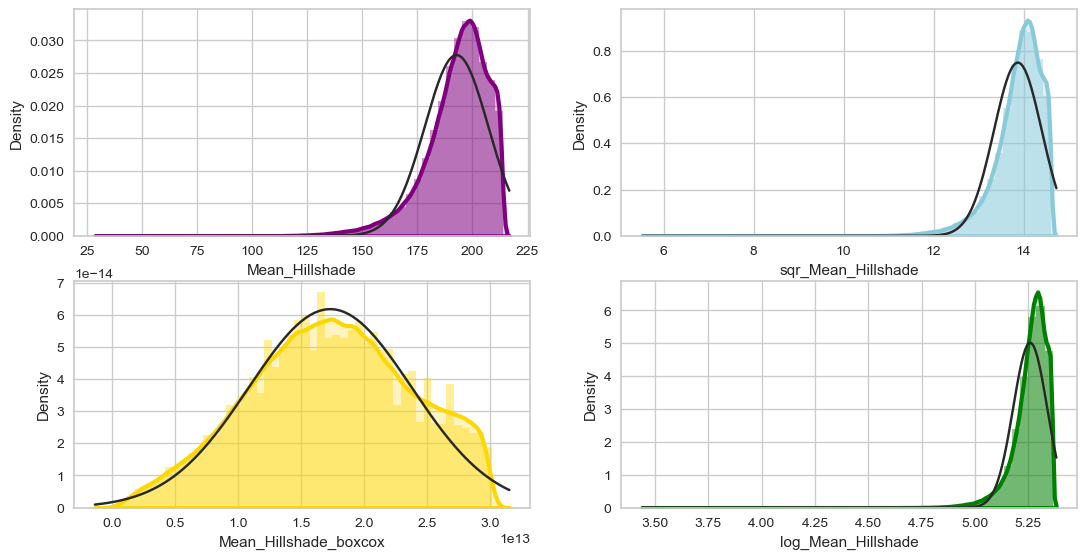

In [43]:
from scipy.stats import norm
import scipy.stats as stats

def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_test['Mean_Hillshade'], 'purple')
f.add_subplot(335)
histPlot(data_test['log_Mean_Hillshade'], 'green')
f.add_subplot(334)
histPlot(data_test['Mean_Hillshade_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_test['sqr_Mean_Hillshade'], 'c')

The distribution did not improve with Square Root and Logarithms Transformation. Hence we use BoxCox which improved the distribution substantially. 

In [44]:
data_test.drop(['log10Mean_Hillshade','log_Mean_Hillshade','sqr_Mean_Hillshade'], axis=1,inplace=True)

<a id='5.2.8.2'></a>
### <font color=green> 5.2.8.2 Hillshade 9am <font>
#### <font color=green> Transformation  <font>

In [45]:
print('\033[95m'+"Skew before transformation\n", data_test['Hillshade_9am'].skew(), 
      "\nmin\n", data_test['Hillshade_9am'].min(),
      "\nmax\n", data_test['Hillshade_9am'].max(),)

Skew before transformation
 -1.184138141158081 
min
 0 
max
 254


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [46]:
data_test['log_Hillshade_9am'] = np.log(data_test['Hillshade_9am']+1)

In [47]:
print('\033[92m'+"Skew after log transformation\n", data_test['log_Hillshade_9am'].skew(), 
      "\nmin\n", data_test['log_Hillshade_9am'].min(),
      "\nmax\n", data_test['log_Hillshade_9am'].max(),)

Skew after log transformation
 -2.920150759278122 
min
 0.0 
max
 5.541263545158426


In [48]:
data_test['sqr_Hillshade_9am'] = data_test['Hillshade_9am']**0.5

In [49]:
print('\033[96m'+"Skew after Square Root transformation\n", data_test['sqr_Hillshade_9am'].skew(), 
      "\nmin\n", data_test['sqr_Hillshade_9am'].min(),
      "\nmax\n", data_test['sqr_Hillshade_9am'].max(),)

Skew after Square Root transformation
 -1.542182078791687 
min
 0.0 
max
 15.937377450509228


In [50]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers, transform training data with Boxcox
data_test['Hillshade_9am_boxcox'], lam  = stats.boxcox(data_test['Hillshade_9am']+1)
#lam is the best lambda for the distribution

In [51]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_test['Hillshade_9am_boxcox'].skew(), 
      "\nmin\n", data_test['Hillshade_9am_boxcox'].min(),
      "\nmax\n", data_test['Hillshade_9am_boxcox'].max(),)

Skew after Boxcox transformation
 -0.14680127554520395 
min
 0.0 
max
 673742890.2101951


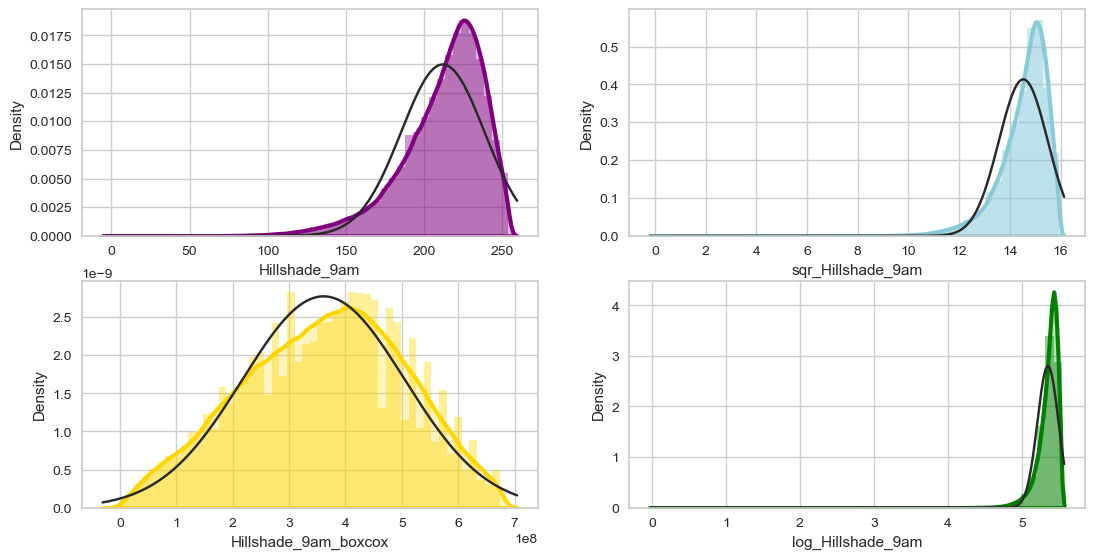

In [52]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_test['Hillshade_9am'], 'purple')
f.add_subplot(335)
histPlot(data_test['log_Hillshade_9am'], 'green')
f.add_subplot(334)
histPlot(data_test['Hillshade_9am_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_test['sqr_Hillshade_9am'], 'c')

BoxCox outperforms the other two for the Hillshade 9am 

In [53]:
data_test.drop(['log_Hillshade_9am','sqr_Hillshade_9am'], axis=1,inplace=True)

<a id='5.2.8.3'></a>
### <font color=green> 5.2.8.3 Hillshade Noon <font>
#### <font color=green> Transformation  <font>

In [54]:
print('\033[95m'+"Skew before transformation\n", data_test['Hillshade_Noon'].skew(), 
      "\nmin\n", data_test['Hillshade_Noon'].min(),
      "\nmax\n", data_test['Hillshade_Noon'].max(),)

Skew before transformation
 -1.062229915803374 
min
 0 
max
 254


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [55]:
data_test['log_Hillshade_Noon'] = np.log(data_test['Hillshade_Noon']+1)

In [56]:
data_test['sqr_Hillshade_Noon'] = data_test['Hillshade_Noon']**0.5

Box Coc is outperforming the other transformations for Hillshade Noon

In [57]:
data_test.drop(['log_Hillshade_Noon','sqr_Hillshade_Noon'], axis=1,inplace=True)

<a id='5.2.8.4'></a>
### <font color=green> 5.2.8.4 Hillshade 3pm <font>
#### <font color=green> Transformation  <font>

In [58]:
print('\033[95m'+"Skew before transformation\n", data_test['Hillshade_3pm'].skew(), 
      "\nmin\n", data_test['Hillshade_3pm'].min(),
      "\nmax\n", data_test['Hillshade_3pm'].max(),)

Skew before transformation
 -0.2666220506466652 
min
 0 
max
 254


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>, Square root Transformation<font color=gold> and BoxCox Transformation<font>

In [59]:
data_test['log_Hillshade_3pm'] = np.log(data_test['Hillshade_3pm']+1)

In [60]:
print('\033[92m'+"Skew after log transformation\n", data_test['log_Hillshade_3pm'].skew(), 
      "\nmin\n", data_test['log_Hillshade_3pm'].min(),
      "\nmax\n", data_test['log_Hillshade_3pm'].max(),)

Skew after log transformation
 -5.453130001140538 
min
 0.0 
max
 5.541263545158426


In [61]:
data_test['sqr_Hillshade_3pm'] = data_test['Hillshade_3pm']**0.5

In [62]:
print('\033[96m'+"Skew after Square Root transformation\n", data_test['sqr_Hillshade_3pm'].skew(), 
      "\nmin\n", data_test['sqr_Hillshade_3pm'].min(),
      "\nmax\n", data_test['sqr_Hillshade_3pm'].max(),)

Skew after Square Root transformation
 -1.3087116520545705 
min
 0.0 
max
 15.937377450509228


In [63]:
#Now, the Box-Cox transformation also requires our data to only contain positive numbers, transform training data with Boxcox
data_test['Hillshade_3pm_boxcox'], lam  = stats.boxcox(data_test['Hillshade_3pm']+1)
#lam is the best lambda for the distribution

In [64]:
print('\033[93m'+"Skew after Boxcox transformation\n", data_test['Hillshade_3pm_boxcox'].skew(), 
      "\nmin\n", data_test['Hillshade_3pm_boxcox'].min(),
      "\nmax\n", data_test['Hillshade_3pm_boxcox'].max(),)

Skew after Boxcox transformation
 -0.02448190816003877 
min
 0.0 
max
 735.2861210123054


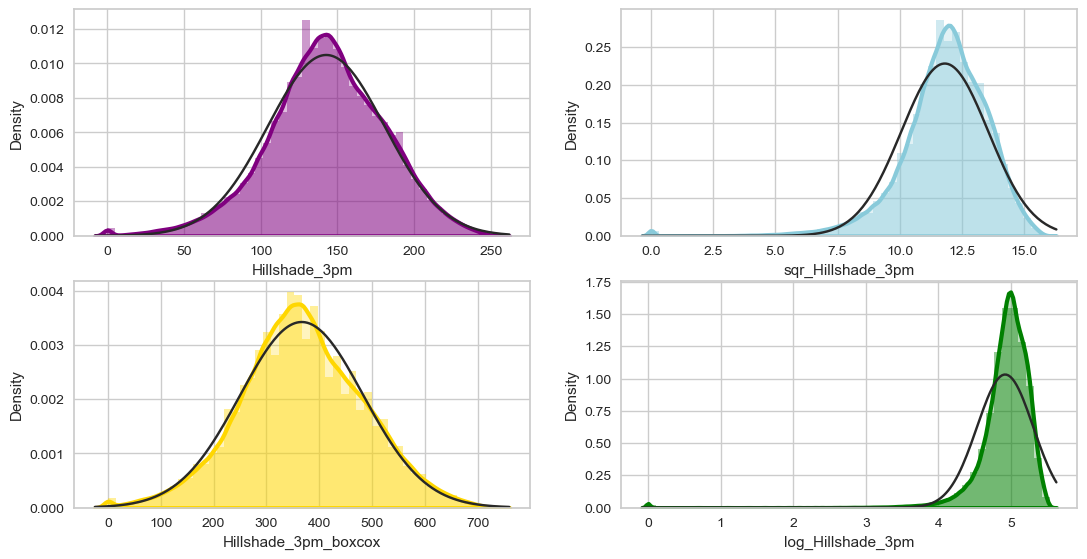

In [65]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_test['Hillshade_3pm'], 'purple')
f.add_subplot(335)
histPlot(data_test['log_Hillshade_3pm'], 'green')
f.add_subplot(334)
histPlot(data_test['Hillshade_3pm_boxcox'], 'gold')                    
f.add_subplot(332)
histPlot(data_test['sqr_Hillshade_3pm'], 'c')

For the Hillshade 3pm the data was not highly skwed, we either keep the original or we can use boxcox as it improved the variables as well. 

In [66]:
data_test.drop(['log_Hillshade_3pm','sqr_Hillshade_3pm'], axis=1,inplace=True)

<a id='5.2.8.5'></a>
### <font color=green> 5.2.8.5 Hillshades  Ratios <font>

In [67]:
data_test['ratio_Hillshade_3pm'] = data_test['Hillshade_3pm']/255
data_test['ratio_Hillshade_Noon'] = data_test['Hillshade_Noon']/255
data_test['ratio_Hillshade_9am'] = data_test['Hillshade_9am']/255

In [68]:
data_test['Hillshade_9am_bin'] = data_test['Hillshade_9am'] > 150
data_test['Hillshade_Noon_bin'] = data_test['Hillshade_Noon'] > 150
data_test['Hillshade_3pm_bin'] = data_test['Hillshade_3pm'] > 150

In [69]:
data_test['Hillshade_9am_bin'] = data_test['Hillshade_9am_bin'].astype(int)
data_test['Hillshade_Noon_bin'] = data_test['Hillshade_Noon_bin'].astype(int)
data_test['Hillshade_3pm_bin'] = data_test['Hillshade_3pm_bin'].astype(int)

In [70]:
data_test['Hillshade_allday_bin'] = data_test['Hillshade_9am_bin'] * data_test['Hillshade_Noon_bin'] * data_test['Hillshade_3pm_bin']

In [71]:
data_test['Hillshade_allday_bin'].value_counts()

0    349714
1    216178
Name: Hillshade_allday_bin, dtype: int64

<a id='5.2.8.6'></a>
### <font color=green> 5.2.8.6 Aspect <font>
#### <font color=green> Transformation  <font>

In [72]:
print('\033[95m'+"Skew before transformation\n", data_test['Aspect'].skew(), 
      "\nmin\n", data_test['Aspect'].min(),
      "\nmax\n", data_test['Aspect'].max(),)

Skew before transformation
 0.4014239594856186 
min
 0 
max
 360


#### <font color=green> Results after logarithm Transformation <font color=darkcyan>and Square root Transformation<font>

In [73]:
data_test['sqr_Aspect'] = data_test['Aspect']**0.5

In [74]:
print('\033[96m'+"Skew after Square Root transformation\n", data_test['sqr_Aspect'].skew(), 
      "\nmin\n", data_test['sqr_Aspect'].min(),
      "\nmax\n", data_test['sqr_Aspect'].max(),)

Skew after Square Root transformation
 -0.1396298942846544 
min
 0.0 
max
 18.973665961010276


In [75]:
data_test['log_Aspect'] = np.log(data_test['Aspect']+1)

In [76]:
print('\033[92m'+"Skew after log transformation\n", data_test['log_Aspect'].skew(), 
      "\nmin\n", data_test['log_Aspect'].min(),
      "\nmax\n", data_test['log_Aspect'].max(),)

Skew after log transformation
 -1.3550359850945586 
min
 0.0 
max
 5.8888779583328805


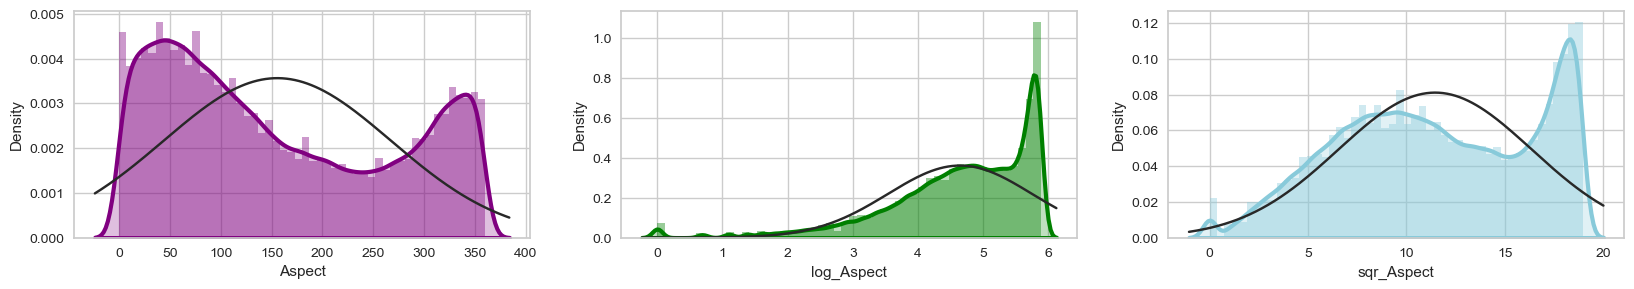

In [77]:
def histPlot(first_feature,col):
    sns.distplot(first_feature,color=col,fit = norm,kde = True,kde_kws = {'shade': True, 'linewidth': 3});

f = plt.figure(figsize=(20,10))
f.add_subplot(331)
histPlot(data_test['Aspect'], 'purple')
f.add_subplot(332)
histPlot(data_test['log_Aspect'], 'green')
#f.add_subplot(334)
#histPlot(data_test['Hillshade_3pm_boxcox'], 'gold')                    
f.add_subplot(333)
histPlot(data_test['sqr_Aspect'], 'c')

For aspect square root turned out to be the best transformation in terms of skeweness. 

Overall, the best transformations done here are square rt, and boxcox. log transformations did not proved to be benefitial

In [78]:
data_test.drop(['log_Aspect'], axis=1,inplace=True)

In here we are transforming the ratios into a unit scale by dividing by its index. We do so because we think it is much easier to understand

In [79]:
data_test['ratio_Hillshade_3pm'] = data_test['Hillshade_3pm']/255
data_test['ratio_Hillshade_Noon'] = data_test['Hillshade_Noon']/255
data_test['ratio_Hillshade_9am'] = data_test['Hillshade_9am']/255


<a id='5.2.8.8'></a>
### <font color=green> 5.2.8.8 Elevation <font>

No transformation is done as it is already very symetric distributed 


In [80]:
print('\033[95m'+"Skew before transformation\n", data_test['Elevation'].skew(), 
      "\nmin\n", data_test['Elevation'].min(),
      "\nmax\n", data_test['Elevation'].max(),)

Skew before transformation
 -0.8165942430160822 
min
 1859 
max
 3858


In [81]:
data_test['binned_elevation'] = [math.floor(v/50.0) for v in data_test['Elevation']]

We are making more features byt summing and substracing different combinations similar in terms of units

Addition and Substraction on the same scale
Using for loop was giving us a bad performance hence we are using the features on the same scale which to add or substract 

In [82]:
data_test['sqr_Road+Fire'] = (data_test['Horizontal_Distance_To_Roadways'] + data_test['Horizontal_Distance_To_Fire_Points'])**0.5
data_test['sqr_Road-Fire'] = (abs(data_test['Horizontal_Distance_To_Roadways'] - data_test['Horizontal_Distance_To_Fire_Points']))**0.5
data_test['sqr_Road+Hydro'] = (data_test['Horizontal_Distance_To_Roadways'] + data_test['Horizontal_Distance_To_Hydrology'])**0.5
data_test['sqr_Road-Hydro'] = (abs(data_test['Horizontal_Distance_To_Roadways'] - data_test['Horizontal_Distance_To_Hydrology']))**0.5
data_test['sqr_Hydro+Fire'] = (data_test['Horizontal_Distance_To_Hydrology'] + data_test['Horizontal_Distance_To_Fire_Points'])**0.5
data_test['sqr_Hydro-Fire'] = (abs(data_test['Horizontal_Distance_To_Hydrology'] - data_test['Horizontal_Distance_To_Fire_Points']))**0.5

data_test['sqr_Road+Fire+Hydro'] = (data_test['Horizontal_Distance_To_Roadways']  + data_test['Horizontal_Distance_To_Fire_Points'] + data_test['Horizontal_Distance_To_Hydrology'])**0.5

data_test['sqr_Ele+Road+Fire+Hydro'] = (data_test['Elevation'] + data_test['Horizontal_Distance_To_Roadways']  + data_test['Horizontal_Distance_To_Fire_Points'] + data_test['Horizontal_Distance_To_Hydrology'])**0.5

data_test['sqr_Ele+road'] = (data_test['Elevation'] + data_test['Horizontal_Distance_To_Roadways'])**0.5
data_test['sqr_Ele-road'] = (abs(data_test['Elevation'] - data_test['Horizontal_Distance_To_Roadways']))**0.5
data_test['sqr_Ele+fire'] = (data_test['Elevation'] + data_test['Horizontal_Distance_To_Fire_Points'])**0.5
data_test['sqr_Ele-fire'] = (abs(data_test['Elevation'] - data_test['Horizontal_Distance_To_Fire_Points']))**0.5
data_test['sqr_Ele+hydro'] = (data_test['Elevation'] + data_test['Horizontal_Distance_To_Hydrology'])**0.5
data_test['sqr_Ele-hydro'] = (abs(data_test['Elevation'] - data_test['Horizontal_Distance_To_Hydrology']))**0.5

### <font color=green> 5.2.9 Geoclimate grouping  <font>

#### <font color=green> 5.2.9.1 Climatic feature engineering to group soils  <font>

#### <font color=green> 5.2.9.2 Climatic Zone feature engineering to group soils  <font>

In [83]:
data_test["Lower_Montane_Climate"] = data_test.loc[:,data_test.columns.str.contains("^Soil_Type[23456]$")].max(axis=1)

In [84]:
data_test['Montane_Dry_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[78]$")].max(axis=1)

In [85]:
data_test['Montane_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[1][0123]$|Soil_Type[9]$")].max(axis=1)

In [86]:
data_test['Montane_Dry_and_Montane_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[1][45]$")].max(axis=1)

In [87]:
data_test['Montante_and_Subalpine_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[1][678]$")].max(axis=1)


In [88]:
data_test['Subalpine_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type19$|^Soil_Type[2][0-9]$|^Soil_Type[3][0-4]$")].max(axis=1)


In [89]:
data_test['Alpine_Climate'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[3][56789]$|Soil_Type40")].max(axis=1)

#### <font color=green> 5.2.9.2 Geological feature engineering to group soils  <font>

In [90]:
data_test['Alluvium_Soil'] = data_test.loc[:,data_test.columns.str.contains("^Soil_Type[1][45679]$|^Soil_Type[2][01]$")].max(axis=1)

In [91]:
data_test['Glacial_Soil'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[9]$|^Soil_Type[2][23]$")].max(axis=1)

In [92]:
data_test['Mixed_Sedimentary_Soil'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[7-8]$")].max(axis=1)

In [93]:
data_test['Igneus_and_Metamorphic_Soil'] =data_test.loc[:,data_test.columns.str.contains("^Soil_Type[1-6]$|^Soil_Type[1][01238]$|^Soil_Type[3-4]\d$|^Soil_Type[2][4-9]$")].max(axis=1)

In [94]:
data_test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Constant Term,Elevation^2,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,binned_elevation,sqr_Road+Fire,sqr_Road-Fire,sqr_Road+Hydro,sqr_Road-Hydro,sqr_Hydro+Fire,sqr_Hydro-Fire,sqr_Road+Fire+Hydro,sqr_Ele+Road+Fire+Hydro,sqr_Ele+road,sqr_Ele-road,sqr_Ele+fire,sqr_Ele-fire,sqr_Ele+hydro,sqr_Ele-hydro,Lower_Montane_Climate,Montane_Dry_Climate,Montane_Climate,Montane_Dry_and_Montane_Climate,Montante_and_Subalpine_Climate,Subalpine_Climate,Alpine_Climate,Alluvium_Soil,Glacial_Soil,Mixed_Sedimentary_Soil,Igneus_and_Metamorphic_Soil
0,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620,1.0,7182400.0,1253

Based on the medium paper "Preprocessing: Why you should generate polynominal features first before standardizing" mention it is not good practice to standardize the variablesbefore before PolynominalFeatures. This should be done after to not loss the signal of the variables.  

### <font color=green> 5.6 Soil Type Family  <font>

Note: Soil type is a single variable which has been one-hot encoded presumably , so we will reverse engineer the soil type. We will eventually drop the original soil type columns which has the added effect of significantly reducing the total number of features.

In [95]:
# Original soil features
soil_features = [f'Soil_Type{i}' for i in range(1,41)]

In [96]:
# Drop original soil features
data_test.drop(columns = soil_features, inplace = True)

In [97]:
#test if elevation makes a difference to take out with the new interaction model improves
data_test = data_test.drop(['Elevation^2'], axis = 1)
data_test = data_test.drop(['Elevation'], axis = 1)

In [98]:
data_test

,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Elevation_x_Aspect,Elevation_x_Slope,Elevation_x_Horizontal_Distance_To_Hydrology,Elevation_x_Vertical_Distance_To_Hydrology,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Hillshade_9am,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_3pm,Elevation_x_Horizontal_Distance_To_Fire_Points,Aspect_x_Slope,Aspect_x_Horizontal_Distance_To_Hydrology,Aspect_x_Vertical_Distance_To_Hydrology,Aspect_x_Horizontal_Distance_To_Roadways,Aspect_x_Hillshade_9am,Aspect_x_Hillshade_Noon,Aspect_x_Hillshade_3pm,Aspect_x_Horizontal_Distance_To_Fire_Points,Slope_x_Horizontal_Distance_To_Hydrology,Slope_x_Vertical_Distance_To_Hydrology,Slope_x_Horizontal_Distance_To_Roadways,Slope_x_Hillshade_9am,Slope_x_Hillshade_Noon,Slope_x_Hillshade_3pm,Slope_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology_x_Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Hydrology_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_Noon,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Horizontal_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Roadways,Vertical_Distance_To_Hydrology_x_Hillshade_9am,Vertical_Distance_To_Hydrology_x_Hillshade_Noon,Vertical_Distance_To_Hydrology_x_Hillshade_3pm,Vertical_Distance_To_Hydrology_x_Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_3pm,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_x_Hillshade_Noon,Hillshade_9am_x_Hillshade_3pm,Hillshade_9am_x_Horizontal_Distance_To_Fire_Points,Hillshade_Noon_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_3pm_x_Horizontal_Distance_To_Fire_Points,Constant Term,Aspect^2,Slope^2,Horizontal_Distance_To_Hydrology^2,Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Roadways^2,Hillshade_9am^2,Hillshade_Noon^2,Hillshade_3pm^2,Distance_To_Hydrology,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,SqrSlope,sqr_Horizontal_Distance_To_firepoints,Mean_Hillshade,Mean_Hillshade_bin,Mean_Hillshade_boxcox,Hillshade_9am_boxcox,Hillshade_3pm_boxcox,ratio_Hillshade_3pm,ratio_Hillshade_Noon,ratio_Hillshade_9am,Hillshade_9am_bin,Hillshade_Noon_bin,Hillshade_3pm_bin,Hillshade_allday_bin,sqr_Aspect,binned_elevation,sqr_Road+Fire,sqr_Road-Fire,sqr_Road+Hydro,sqr_Road-Hydro,sqr_Hydro+Fire,sqr_Hydro-Fire,sqr_Road+Fire+Hydro,sqr_Ele+Road+Fire+Hydro,sqr_Ele+road,sqr_Ele-road,sqr_Ele+fire,sqr_Ele-fire,sqr_Ele+hydro,sqr_Ele-hydro,Lower_Montane_Climate,Montane_Dry_Climate,Montane_Climate,Montane_Dry_and_Montane_Climate,Montante_and_Subalpine_Climate,Subalpine_Climate,Alpine_Climate,Alluvium_Soil,Glacial_Soil,Mixed_Sedimentary_Soil,Igneus_and_Metamorphic_Soil
0,354,14,0,0,2684,196,214,156,6645,1,0,0,0,948720,37520,0,0,7193120,525280,573520,418080,17808600,4956,0,0,950136,69384,75756,55224,2352330,0,0,37576,2744,2996,2184,93030,0,0,0,0,0,0,0,0,0,0,0,526064,574376,418704,17835180,41944,30576,1302420,33384,1422030,1036620,1.0,125316.0,196.0,0.0,0.0,7203856.0,38416.0,45796.0,24336.0,0.000000,0.000000,51.807335,3.741657,81.516869,188.666667,2.0,1.408834e+13,2.453258e+08,404.860354,0.611765,0.839216,0.768627,1,1,1,1,18.814888,53,96.586749,62.936476,51.807335,51.807335,81.516869,81.516869,96.586749,109.585583,73.239334,2.000000,96.566040,62.968246,51.768716,51.768716,0,0,0,0,0,1,0,0,0,0,1
1,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,34879,0,0,7120682,539283,579528,407816,17909025,0,0,0,0,0,0,0,0,0,0,34502,2613,2808,1976,86775,0,0,0,0,0,0,0,0,0,0,0,533454,573264,403408,17715450,43416,30552,1341675,32832,1441800,10

Removing the original scaled variables did not improve nor worsen the model. Since it does not change much the score, we remove it as we have it double in the model with the scaled features. 

### Locking all features in a csv

For the shake of efficiency, we create a csv file to reuse also later on in part III

In [99]:
data_test_conformed = data_test[['Wilderness_Area4',
 'Subalpine_Climate',
 'Alpine_Climate',
 'sqr_Road-Hydro',
 'sqr_Road-Fire',
 'sqr_Road+Fire',
 'binned_elevation',
 'Wilderness_Area3',
 'Wilderness_Area1',
 'Montane_Climate',
 'Lower_Montane_Climate',
 'Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points',
 'sqr_Road+Fire+Hydro',
 'sqr_Ele-hydro',
 'sqr_Ele+road',
 'sqr_Ele+hydro',
 'sqr_Ele+fire',
 'sqr_Ele+Road+Fire+Hydro',
 'Horizontal_Distance_To_Roadways^2',
 'Hillshade_9am_x_Hillshade_Noon',
 'Elevation_x_Hillshade_Noon',
 'Elevation_x_Hillshade_9am',
 'sqr_Road+Hydro',
 'sqr_Ele-road',
 'sqr_Ele-fire',
 'sqr_Distance_To_Hydrology',
 'Sqr_Horizontal_Distance_To_Roadways',
 'Igneus_and_Metamorphic_Soil',
 'Horizontal_Distance_To_Roadways_x_Hillshade_Noon',
 'Horizontal_Distance_To_Roadways_x_Hillshade_9am',
 'Horizontal_Distance_To_Hydrology_x_Hillshade_3pm',
 'Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points',
 'Hillshade_9am_boxcox',
 'Elevation_x_Horizontal_Distance_To_Roadways',
 'Elevation_x_Horizontal_Distance_To_Hydrology']]

In [100]:
data_test_conformed.head(2)

,Wilderness_Area4,Subalpine_Climate,Alpine_Climate,sqr_Road-Hydro,sqr_Road-Fire,sqr_Road+Fire,binned_elevation,Wilderness_Area3,Wilderness_Area1,Montane_Climate,Lower_Montane_Climate,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,sqr_Road+Fire+Hydro,sqr_Ele-hydro,sqr_Ele+road,sqr_Ele+hydro,sqr_Ele+fire,sqr_Ele+Road+Fire+Hydro,Horizontal_Distance_To_Roadways^2,Hillshade_9am_x_Hillshade_Noon,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_9am,sqr_Road+Hydro,sqr_Ele-road,sqr_Ele-fire,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,Igneus_and_Metamorphic_Soil,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_boxcox,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Horizontal_Distance_To_Hydrology
0,0,1,0,51.807335,62.936476,96.586749,53,0,1,0,0,17835180,96.586749,51.768716,73.239334,51.768716,96.566040,109.585583,7203856.0,41944,573520,525280,51.807335,2.000000,62.968246,0.0,51.807335,1,574376,526064,0,1422030,2.453258e+08,7193120,0
1,0,1,0,51.516987,63.411355,96.586749,53,0,1,0,0,17715450,96.586749,51.797683,73.054774,51.797683,96.736756,109.599270,7043716.0,43416,579528,539283,51.516987,5.385165,63.182276,0.0,51.516987,1,573264,533454,0,1441800,2.706180e+08,7120682,0


## Standardization

In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
scaler= StandardScaler()
column_list = data_test_conformed.columns


In [103]:
scale_numerical  = [column for column in column_list if 'Soil' not in column and 'Wilderness_Area' not in  column and 'Aspect_North' not in  column and 'Climate' not in  column and 'Family' not in  column and 'Type' not in  column and 'complex' not in  column and 'Aspect_East' not in  column and 'Aspect_South' not in  column and 'Aspect_West' not in  column ]
scale_categorial= [column for column in column_list if column not in scale_numerical ]

In [104]:
numerical_test = data_test_conformed.filter(items=scale_numerical)
categorial_test = data_test_conformed.filter(items=scale_categorial)

In [105]:
data_test_conformed[scale_numerical] = scaler.fit_transform(data_test_conformed[scale_numerical])


C:\Users\Pedro\AppData\Local\Temp\ipykernel_369412\595683994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_conformed[scale_numerical] = scaler.fit_transform(data_test_conformed[scale_numerical])


In [106]:
data_test_conformed.head(2)

,Wilderness_Area4,Subalpine_Climate,Alpine_Climate,sqr_Road-Hydro,sqr_Road-Fire,sqr_Road+Fire,binned_elevation,Wilderness_Area3,Wilderness_Area1,Montane_Climate,Lower_Montane_Climate,Horizontal_Distance_To_Roadways_x_Horizontal_Distance_To_Fire_Points,sqr_Road+Fire+Hydro,sqr_Ele-hydro,sqr_Ele+road,sqr_Ele+hydro,sqr_Ele+fire,sqr_Ele+Road+Fire+Hydro,Horizontal_Distance_To_Roadways^2,Hillshade_9am_x_Hillshade_Noon,Elevation_x_Hillshade_Noon,Elevation_x_Hillshade_9am,sqr_Road+Hydro,sqr_Ele-road,sqr_Ele-fire,sqr_Distance_To_Hydrology,Sqr_Horizontal_Distance_To_Roadways,Igneus_and_Metamorphic_Soil,Horizontal_Distance_To_Roadways_x_Hillshade_Noon,Horizontal_Distance_To_Roadways_x_Hillshade_9am,Horizontal_Distance_To_Hydrology_x_Hillshade_3pm,Hillshade_Noon_x_Horizontal_Distance_To_Fire_Points,Hillshade_9am_boxcox,Elevation_x_Horizontal_Distance_To_Roadways,Elevation_x_Horizontal_Distance_To_Hydrology
0,0,1,0,0.533966,1.961485,1.855346,-1.062112,0,1,0,0,2.008485,1.771137,-0.021171,0.097371,-1.440131,2.810140,1.672989,-0.088577,-0.769768,-0.995703,-1.042211,0.184814,-2.670861,2.258291,-2.216973,0.365908,1,0.109239,0.065977,-1.148393,3.220548,-0.805786,0.004675,-1.209463
1,0,1,0,0.517989,1.992011,1.855346,-1.062112,0,1,0,0,1.989157,1.771137,-0.011028,0.081104,-1.431799,2.828038,1.673960,-0.105509,-0.562214,-0.929271,-0.902578,0.166271,-2.397608,2.276083,-2.216973,0.348284,1,0.106183,0.087711,-1.148393,3.285827,-0.629869,-0.010073,-1.209463


This code below have all features that we did in the feature engineering part and transport this to csv before we actually use the feature selection methods and select only few variables. 

In [107]:
#Only X_Train replacement
data_test_conformed.to_csv('selected_features_test.csv')
